### Trabajo Práctico Final - Inteligencia Artificial Embebida

Alan Churichi

In [1]:
%load_ext lab_black

from scipy import signal
from scipy.fft import fft, fftfreq
from scipy.io import wavfile
from sklearn import tree
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
import collections
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import serial
import sys

Lo primero que se hace es descargar el dataset.

In [2]:
BASE_PATH = os.path.join("/tf/notebooks/CEIA/ia-embebida/tp-final")
DATASET_PATH = os.path.join(BASE_PATH, "dataset-audio")
AUDIO_PATH = os.path.join(DATASET_PATH, "audio")

!wget --no-clobber https://www.dropbox.com/s/d12x5vknrk9yek1/data.zip -P {AUDIO_PATH}
!wget --no-clobber https://www.dropbox.com/s/z1cwznln0gfpw32/train_labels.csv -P {DATASET_PATH}
!unzip -j -n {AUDIO_PATH}/data.zip -d {AUDIO_PATH}

File ‘/tf/notebooks/CEIA/ia-embebida/tp-final/dataset-audio/audio/data.zip’ already there; not retrieving.

File ‘/tf/notebooks/CEIA/ia-embebida/tp-final/dataset-audio/train_labels.csv’ already there; not retrieving.

Archive:  /tf/notebooks/CEIA/ia-embebida/tp-final/dataset-audio/audio/data.zip


Cargamos el dataset, tanto audio como labels.

In [3]:
ANNOTATIONS_FILE = os.path.join(DATASET_PATH, "train_labels.csv")


def load_dataset(data_path, annotations_file):
    df = pd.read_csv(annotations_file)
    data = []
    for filename_id in df["filename"]:
        filename = f"{str(filename_id).zfill(4)}.wav"
        audio_file = os.path.join(data_path, filename)
        _, audio = wavfile.read(audio_file)
        data.append(audio.astype(float))
    return data, df["label"].to_numpy()


data, labels = load_dataset(AUDIO_PATH, ANNOTATIONS_FILE)

Definimos todas las funciones que vamos a utilizar para preprocesar los datos antes de entrenar el modelo.

In [4]:
# Se escalan los datos int16 a valores flotantes entre -0.5 y 0.5
def scale(data):
    max_val = 32767
    min_val = -32768
    return [(event - min_val) / (max_val - min_val) - 0.5 for event in data]


# Se calcula el valor absoluto para cada valor en los datos
def absolute(data):
    return [np.abs(event) for event in data]


# Se obtiene la envolvente de la señal aplicando un filtro pasabajos
def envelope(data, cutoff_freq, samplerate):
    sos_butter = signal.butter(2, cutoff_freq, "lowpass", output="sos", fs=samplerate)
    return [signal.sosfiltfilt(sos_butter, event, axis=0) for event in data]


# Se reduce el muestreo de la señal, nos quedamos con 1 de cada x valores
def decimation(data, samplerate, scale):
    data_dec = [event[::scale] for event in data]
    samplerate_dec = samplerate / scale
    return data_dec, samplerate_dec


# Se aplica un threshold, luego se calcula el signo de la pendiente de la señal y se genera un vector con la duración
def slope_sign(data, threshold):
    sign = []
    duration = []
    events_above_thres = [event >= threshold for event in data]
    for event, above_thres in zip(data, events_above_thres):
        sign.append(np.sign(np.diff(event, append=0)) * above_thres)
        duration.append(np.ones_like(event) * above_thres)
    return sign, duration


# Dado un vector con la duración de la señal se calcula la duración en segundos
def calc_duration(data, samplerate):
    return [np.sum(event) / samplerate for event in data]


# Se calcula el número de cruces por cero
def calc_zero_crossing(data):
    return [np.count_nonzero(np.abs(np.diff(event))) for event in data]


# Se calcula la amplitud, es decir el valor máximo
def calc_amplitude(data):
    return [np.max(event) for event in data]


# Se calcula la simetría de la señal
def calc_ratio(data):
    ratio_val = lambda ev, max_pos: np.trapz(ev[:max_pos], axis=0) / np.trapz(
        ev, axis=0
    )
    return [ratio_val(event, np.argmax(event)) for event in data]


# Se calcula la desviación estandar de la señal
def calc_std(data):
    return [np.std(event) for event in data]


# Se grafica la señal con los resultados a lo largo de preprocesamiento
def plot_example(
    data_scaled,
    data_envelope,
    envelope_slope_sign,
    signal_duration,
    samplerate,
    samplerate_dec,
    example,
):
    sample_event_scaled = data_scaled[example]
    event_duration = len(sample_event_scaled) / samplerate
    timeline = np.linspace(0, event_duration, num=len(sample_event_scaled))

    sample_event_envelope = data_envelope[example]
    event_duration_dec = len(sample_event_envelope) / samplerate_dec
    timeline_dec = np.linspace(0, event_duration_dec, num=len(sample_event_envelope))

    f, axes = plt.subplots(4, sharex=True, figsize=(20, 15))

    axes[0].plot(timeline, sample_event_scaled)
    axes[0].set_xlim([0, event_duration])
    axes[0].set_title("Original")

    axes[1].plot(timeline_dec, sample_event_envelope)
    axes[1].set_xlim([0, event_duration_dec])
    axes[1].set_title("Envolvente")

    axes[2].plot(timeline_dec, envelope_slope_sign[example])
    axes[2].set_xlim([0, event_duration_dec])
    axes[2].set_title("Cruces por cero")

    axes[3].plot(timeline_dec, signal_duration[example])
    axes[3].set_xlim([0, event_duration_dec])
    axes[3].set_title("Duracion")

    f.show()

El siguiente paso es armar nuestro propio pipeline con las funciones definidas anteriormente para acondicionar los datos.

array([[0.42131519, 6.        , 0.5       , 0.55812695, 0.05447687],
       [0.37596372, 5.        , 0.31330587, 0.62925759, 0.03289615],
       [0.36326531, 7.        , 0.19709316, 0.57451924, 0.02304588],
       ...,
       [0.22086168, 3.        , 0.09766537, 0.58668405, 0.01624799],
       [0.2031746 , 3.        , 0.08045319, 0.59040862, 0.01315449],
       [0.62539683, 8.        , 0.24767681, 0.31811127, 0.03333723]])

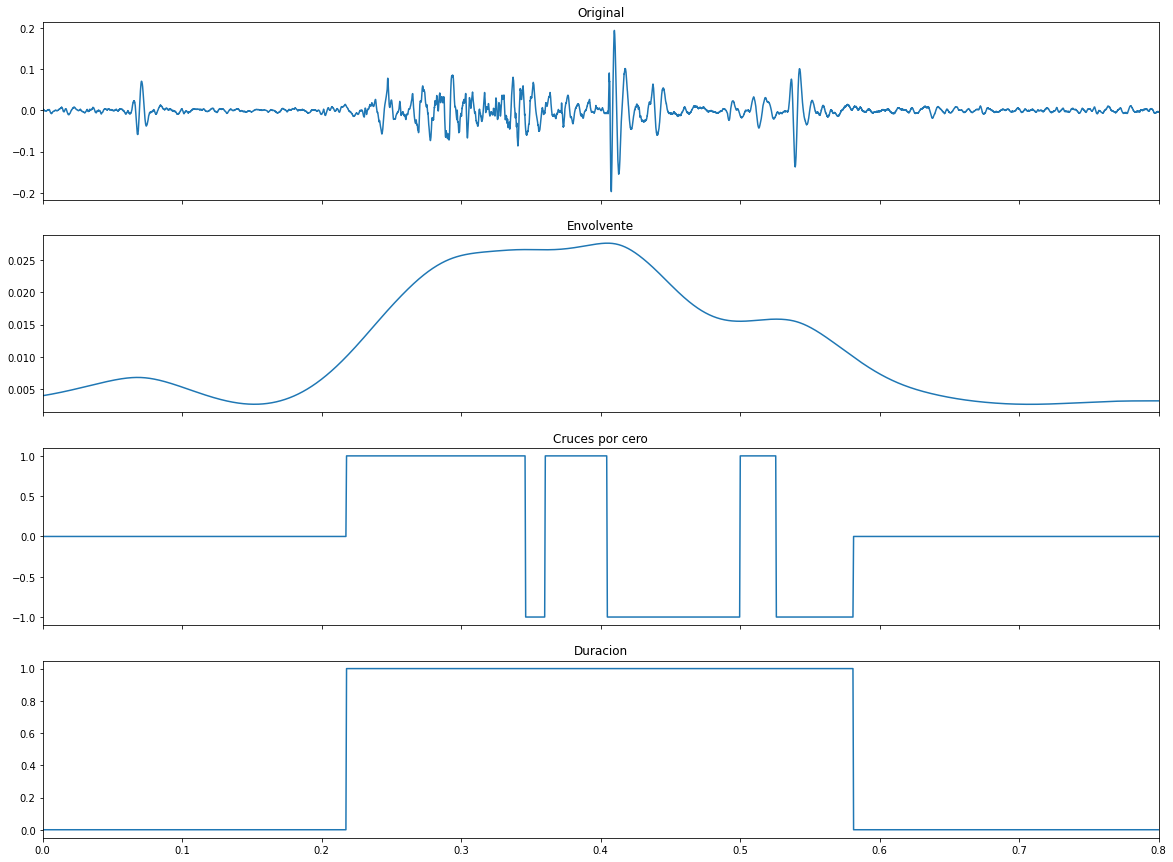

In [5]:
def preprocess(data, samplerate, show_example=-1):
    data_scaled = scale(data)
    data_abs = absolute(data_scaled)
    data_envelope = envelope(data_abs, 5, samplerate)  # 5 Hz
    data_envelope_dec, samplerate_dec = decimation(data_envelope, samplerate, 10)
    envelope_slope_sign, signal_duration = slope_sign(data_envelope_dec, 0.010)

    duration = calc_duration(signal_duration, samplerate_dec)
    zero_crossing = calc_zero_crossing(envelope_slope_sign)
    amplitude = calc_amplitude(data_abs)
    ratio = calc_ratio(data_envelope)
    std = calc_std(data_scaled)

    if show_example >= 0:
        plot_example(
            data_scaled,
            data_envelope_dec,
            envelope_slope_sign,
            signal_duration,
            samplerate,
            samplerate_dec,
            show_example,
        )

    return np.array([duration, zero_crossing, amplitude, ratio, std]).transpose()


samplerate = 22050
X_data = preprocess(data, samplerate, 2)
X_data

Como la UART del microcontrolador trabaja con datos de 8 bits escalamos los resultados a valores uint8.

In [6]:
def scale_to_uint8(data):
    return (
        np.array(
            [
                data[:, 0] * 256,
                data[:, 1],
                data[:, 2] * 256,
                data[:, 3] * 256,
                data[:, 4] * 256,
            ]
        )
        .transpose()
        .astype(int)
    )


X_data = scale_to_uint8(X_data)

Utilizamos Sklearn para crear un DecissionTree y entrenarlo con los datos preprocesados.

In [7]:
def train_model(
    data,
    labels,
    max_depth,
    min_samples_leaf,
    test_size,
    random_state,
    columns=[],
    verbose=True,
):
    # Split en datasets de train y test
    X_train, X_test, y_train, y_test = train_test_split(
        data, labels, test_size=test_size, random_state=random_state
    )

    # Se crea y entrena el modelo
    model = DecisionTreeClassifier(
        max_depth=max_depth, min_samples_leaf=min_samples_leaf
    )
    model.fit(X_train, y_train)

    # Se muestran los resultados del modelo
    if verbose:
        y_pred = model.predict(X_test)
        sc = balanced_accuracy_score(y_test, y_pred)
        print(f"{sc:.3f} balanced accuracy\n")

        tree_rules = export_text(model, feature_names=columns)
        print(tree_rules)

    return model


columns = ["Duracion", "Cruces", "Maximo", "Simetria", "Desvio"]
max_depth = 3
min_samples_leaf = 1
test_size = 0.33
random_state = 42

model = train_model(
    X_data, labels, max_depth, min_samples_leaf, test_size, random_state, columns
)

0.684 balanced accuracy

|--- Maximo <= 50.50
|   |--- Maximo <= 39.50
|   |   |--- Simetria <= 64.50
|   |   |   |--- class: 1
|   |   |--- Simetria >  64.50
|   |   |   |--- class: 1
|   |--- Maximo >  39.50
|   |   |--- Simetria <= 95.50
|   |   |   |--- class: 0
|   |   |--- Simetria >  95.50
|   |   |   |--- class: 1
|--- Maximo >  50.50
|   |--- Simetria <= 127.50
|   |   |--- Cruces <= 4.50
|   |   |   |--- class: 0
|   |   |--- Cruces >  4.50
|   |   |   |--- class: 2
|   |--- Simetria >  127.50
|   |   |--- Simetria <= 214.50
|   |   |   |--- class: 2
|   |   |--- Simetria >  214.50
|   |   |   |--- class: 0



Con 3 niveles de profundidad, la score es de 0.684

Vemos que las columnas de `Duracion` y `Desvio` no intervienen en la clasificación, por lo que podemos removerlos sin afectar la performance.

In [8]:
X_data = X_data[:, 1:-1]
columns = columns[1:-1]

model = train_model(
    X_data, labels, max_depth, min_samples_leaf, test_size, random_state, columns
)

0.684 balanced accuracy

|--- Maximo <= 50.50
|   |--- Maximo <= 39.50
|   |   |--- Simetria <= 64.50
|   |   |   |--- class: 1
|   |   |--- Simetria >  64.50
|   |   |   |--- class: 1
|   |--- Maximo >  39.50
|   |   |--- Simetria <= 95.50
|   |   |   |--- class: 0
|   |   |--- Simetria >  95.50
|   |   |   |--- class: 1
|--- Maximo >  50.50
|   |--- Simetria <= 127.50
|   |   |--- Cruces <= 4.50
|   |   |   |--- class: 0
|   |   |--- Cruces >  4.50
|   |   |   |--- class: 2
|   |--- Simetria >  127.50
|   |   |--- Simetria <= 214.50
|   |   |   |--- class: 2
|   |   |--- Simetria >  214.50
|   |   |   |--- class: 0



Estas reglas de decisión se implementan en el microcontrolador para luego enviar los datos preprocesados por el puerto serie y hacer la inferencia en el ESP.

In [9]:
PORT = "/dev/ttyUSB0"
BAUD_RATE = 115200

serial_port = serial.Serial(PORT, BAUD_RATE, timeout=0.25)
serial_port.flushInput()

predictions_esp = []
for event in X_data:
    [serial_port.write(int(value).to_bytes(1, "little")) for value in event]
    byte = serial_port.read(1)
    result = int.from_bytes(byte, "little")
    predictions_esp.append(result)

serial_port.close()

In [10]:
predictions = model.predict(X_data)

print(f"Equal? {np.array_equal(predictions, predictions_esp)}")
print(f"Predictions sample: {predictions[:15].tolist()}")
print(f"Predictions ESP sample: {predictions_esp[:15]}")

Equal? True
Predictions sample: [2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1]
Predictions ESP sample: [2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1]


Conclusiones:

- Vemos que los resultados de las predicciones del ESP son iguales que las predicciones en Python, esto indica que el algoritmo se implementó correctamente en el microcontrolador.
- Enviar solo 3 valores (de 8 bits) por muestra hace que el algoritmo sea muy rápido. Si se enviara la señal de audio, el tiempo de procesamiento sería en el micro sería mayor, y el cuello de botella probablemente estaría dado por la velocidad de transmisión de la UART.
- Se puede seguir añadiendo profundidad al árbol, pero utilizar más niveles no aporta mejores resultados.
- Se podría hacer una optimización de hiperparámetros generando conjuntos de datos preprocesados con distintos valores de threshold, decimación, filtrado y entrenar árboles de decisión de distintas profundidades para encontrar la combinación que maximice la accuracy.